In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap

In [ ]:
!unzip /content/drive/MyDrive/MLChallengesProject/MLProjectData.zip

Streaming output truncated to the last 5000 lines.
  inflating: AllDatasets/train/ESP_012588_1855_RED-0098.jpg  
  inflating: AllDatasets/train/ESP_012588_1855_RED-0315.jpg  
  inflating: AllDatasets/train/ESP_012588_1855_RED-0217-r270.jpg  
  inflating: AllDatasets/train/ESP_027199_1975_RED-0143-r180.jpg  
  inflating: AllDatasets/train/PSP_008027_2070_RED-0244-r90.jpg  
  inflating: AllDatasets/train/ESP_026472_1410_RED-0091-fv.jpg  
  inflating: AllDatasets/train/PSP_001481_1875_RED-0146-fv.jpg  
  inflating: AllDatasets/train/ESP_020606_1445_RED-0378-r180.jpg  
  inflating: AllDatasets/train/ESP_018299_2245_RED-0061.jpg  
  inflating: AllDatasets/train/ESP_034268_1795_RED-0353-fh.jpg  
  inflating: AllDatasets/train/ESP_016781_2055_RED-0008.jpg  
  inflating: AllDatasets/train/PSP_006921_1830_RED-0034-fv.jpg  
  inflating: AllDatasets/train/ESP_016730_1960_RED-0044-fv.jpg  
  inflating: AllDatasets/train/ESP_019559_1390_RED-0780.jpg  
  inflating: AllDatasets/train/ESP_012971_2015_

In [1]:
import numpy as np
import torch
import os
from collections import defaultdict, Counter
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
import cv2
import sklearn
import matplotlib.pyplot as plt


In [3]:
torch.__version__

'1.13.1+cu116'

In [ ]:
dev =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
dev

device(type='cuda')

In [ ]:
#Transforms for augmentation pipeline
train_transforms = A.Compose(
    [
            A.CLAHE(),
            A.RandomRotate90(),
            A.Transpose(),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
            A.Blur(blur_limit=3),
            A.OpticalDistortion(),
            A.GridDistortion(),
            A.HueSaturationValue(),
            ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        ToTensorV2(),
    ]
)

In [ ]:
# Pytorch weighted sampler
def weightedSampler(annotations_file):
  img_labels = pd.read_csv(annotations_file, delimiter=' ',header=None, names=['name', 'class'])
  labels = img_labels['class'].tolist()
  class_count = list(Counter(labels).values())
  num_samples = sum(class_count)
  class_weights = [num_samples/class_count[i] for i in range(len(class_count))]
  weights = [class_weights[labels[i]] for i in range(int(num_samples))]
  print(class_weights)
  print(class_count)

  return weights, num_samples
  

In [ ]:
def weightedSamplerTrain(train_labels):
  class_count = list(Counter(train_labels).values())
  num_samples = sum(class_count)
  class_weights = [num_samples/class_count[i] for i in range(len(class_count))]
  weights = [class_weights[train_labels[i]] for i in range(int(num_samples))]
  return weights, num_samples

In [ ]:
#Building Custom data loader 
class hiriseImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, classmap_file,  transform=None, target_transform=None):
      self.img_labels = pd.read_csv(annotations_file, delimiter=' ',header=None)
      self.class_map = pd.read_csv(classmap_file, header=None, names=['class', 'name'])
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform
  
  def __len__(self):
      return len(self.img_labels)

  def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
      image = cv2.imread(img_path)
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      label = self.img_labels.iloc[idx, 1]
      class_label_map = self.class_map.loc[self.class_map['class'] == label].name.item()
      if self.transform:
          image = self.transform(image=gray_image)["image"]
      if self.target_transform:
          label = self.target_transform(label)
      return image, label, class_label_map

In [ ]:
_, _, files = next(os.walk("/content/AllDatasets/train"))
file_count = len(files)
print(file_count)

54780


In [ ]:
train_dataset_subset = hiriseImageDataset('/content/train_labels.txt', '/content/AllDatasets/train', '/content/landmarks_map-proj-v3_classmap.csv',transform=train_transforms)
valid_dataset_subset = hiriseImageDataset('/content/val_labels.txt', '/content/AllDatasets/val', '/content/landmarks_map-proj-v3_classmap.csv',transform=test_transforms)
test_dataset = hiriseImageDataset('/content/test_labels.txt', '/content/AllDatasets/test', '/content/landmarks_map-proj-v3_classmap.csv',transform=test_transforms)
# print(train_dataset[9878][1])
# #Splitting the dataset into train and valid
# num_train = len(train_dataset)
# indices = list(range(num_train))
# train_indices, val_indices = sklearn.model_selection.train_test_split(indices, test_size=0.33, random_state=42)
# train_dataset_subset = torch.utils.data.Subset(train_dataset, train_indices)
# valid_dataset_subset = torch.utils.data.Subset(valid_dataset, val_indices)

In [ ]:
print(len(train_dataset_subset))
print(len(valid_dataset_subset))

54772
26300


In [ ]:
# train_labels = [train_dataset_subset.__getitem__(i)[1] for i in range(0, train_dataset_subset.__len__())]

In [ ]:
weights, num_samples  = weightedSampler('/content/train_labels.txt')

[1.196391516131146, 326.0238095238095, 14.948689956331878, 31.085130533484676, 64.58962264150944, 64.06081871345029, 145.28381962864722, 41.58845861807137]
[45781, 168, 3664, 1762, 848, 855, 377, 1317]


In [ ]:
print(weights)

[1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516131146, 1.196391516

In [ ]:
weighted_sampler = WeightedRandomSampler(weights=torch.DoubleTensor(weights), num_samples=int(num_samples), replacement=False)

In [ ]:
print('Size of train dataset: ', len(train_dataset_subset))
print('Size of valid dataset: ', len(valid_dataset_subset))
# print('Size of train dataset: ', len(test_dataset))

Size of train dataset:  54772
Size of valid dataset:  26300


The shape of tensor for 50th image in train dataset:  torch.Size([1, 227, 227])
The label for 50th image in train dataset:  0
The type of image is :  int64
The image plotted is as below : 


/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/functional.py:358: UserWarning: HueSaturationValue: hue_shift and sat_shift are not applicable to grayscale image. Set them to 0 or use RGB image
  warn(
<ipython-input-18-0ec378596bdf>:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  plt.imshow(train_dataset_subset[49][0].T, cmap='gray', vmin=0, vmax=255)


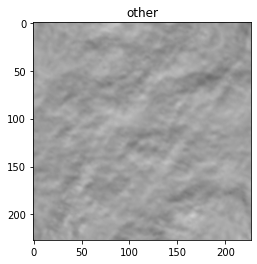

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset_subset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset_subset[49][1])
print('The type of image is : ',train_dataset_subset[49][1].dtype )
print('The image plotted is as below : ')
plt.imshow(train_dataset_subset[49][0].T, cmap='gray', vmin=0, vmax=255)
plt.title(train_dataset_subset[49][2])
plt.show()

In [ ]:
idx_to_class = pd.read_csv('/content/landmarks_map-proj-v3_classmap.csv', index_col=0, header=None, squeeze=True).to_dict()

In [ ]:
# visualizing augmentations
def visualize_augmentations(dataset, idx = 0, samples=10, cols=5, random_img = False):
  dataset = copy.deepcopy(dataset)
  # dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
  rows = samples // cols
  
      
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
  for i in range(samples):
      if random_img:
          idx = np.random.randint(1,len(dataset))
      image, lab, class_label_map = dataset[idx]
      ax.ravel()[i].imshow(image.T,cmap='gray', vmin=0, vmax=255)
      ax.ravel()[i].set_axis_off()
      ax.ravel()[i].set_title(idx_to_class[lab])
  plt.tight_layout(pad=1)
  plt.show()    

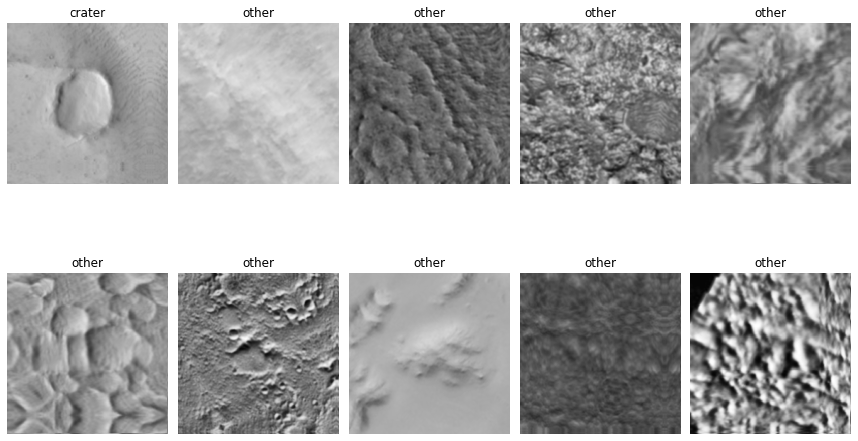

In [ ]:
visualize_augmentations(train_dataset_subset,np.random.randint(1,len(train_dataset_subset)), random_img = True)


In [ ]:
BATCH_SIZE = 64
train_iterator = DataLoader(train_dataset_subset,  shuffle=True,
                                 batch_size = BATCH_SIZE)

valid_iterator = DataLoader(valid_dataset_subset,
                                 batch_size = BATCH_SIZE)


test_iterator = DataLoader(test_dataset, 
                                batch_size = BATCH_SIZE)

test_gradcam_iterator = DataLoader(test_dataset, batch_size = 1)

In [ ]:
pretrained_model = models.resnet34(pretrained = True).to(dev)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in pretrained_model.parameters():
    param.requires_grad = False 

In [ ]:
IN_FEATURES = pretrained_model.fc.in_features 
pretrained_model.fc = nn.Sequential(
               nn.Linear(IN_FEATURES, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 8)).to(dev)
pretrained_model.conv1 = torch.nn.Conv2d(1,64,kernel_size = (7,7),stride = (2,2), padding = (3,3), bias = False) .to(dev)


In [ ]:
weights = 1./ torch.tensor([45781, 168, 3664, 1762, 848, 855, 377, 1317]).to('cuda')
print(weights)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(pretrained_model.fc.parameters())

tensor([2.1843e-05, 5.9524e-03, 2.7293e-04, 5.6754e-04, 1.1792e-03, 1.1696e-03,
        2.6525e-03, 7.5930e-04], device='cuda:0')


In [ ]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
    self.logits = logits
    self.reduce = reduce

  def forward(self, inputs, targets):
    BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

    pt = torch.exp(-BCE_loss)
    F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

    if self.reduce:
      return torch.mean(F_loss)
    else:
      return F_loss

In [ ]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight) 
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
criterion = FocalLoss()

In [ ]:

datasets = {'train':train_dataset_subset, 'valid':valid_dataset_subset}

In [ ]:
dataloaders = {'train': train_iterator, 'valid':valid_iterator}

In [ ]:
def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels,_ in dataloaders[phase]:
                inputs = inputs.float().to(dev)
                labels = labels.to(dev)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
model_trained = train_model(pretrained_model, criterion, optimizer, num_epochs=20)


Epoch 1/20
----------


HueSaturationValue: hue_shift and sat_shift are not applicable to grayscale image. Set them to 0 or use RGB image


train loss: 0.0925, acc: 0.8558
valid loss: 0.0819, acc: 0.8785
Epoch 2/20
----------
train loss: 0.0599, acc: 0.8697
valid loss: 0.0788, acc: 0.8820
Epoch 3/20
----------
train loss: 0.0536, acc: 0.8721
valid loss: 0.0637, acc: 0.8914
Epoch 4/20
----------
train loss: 0.0513, acc: 0.8745
valid loss: 0.0599, acc: 0.8918
Epoch 5/20
----------
train loss: 0.0501, acc: 0.8761
valid loss: 0.0673, acc: 0.8898
Epoch 6/20
----------
train loss: 0.0483, acc: 0.8762
valid loss: 0.0679, acc: 0.8908
Epoch 7/20
----------
train loss: 0.0479, acc: 0.8780
valid loss: 0.0635, acc: 0.8932
Epoch 8/20
----------
train loss: 0.0457, acc: 0.8797
valid loss: 0.0546, acc: 0.8969
Epoch 9/20
----------
train loss: 0.0429, acc: 0.8818
valid loss: 0.0647, acc: 0.8944
Epoch 10/20
----------
train loss: 0.0448, acc: 0.8801
valid loss: 0.0489, acc: 0.8986
Epoch 11/20
----------
train loss: 0.0428, acc: 0.8810
valid loss: 0.0698, acc: 0.8948
Epoch 12/20
----------
train loss: 0.0425, acc: 0.8829
valid loss: 0.0627,

In [ ]:
torch.save(model_trained.state_dict(), '/content/drive/MyDrive/MLChallengesProject/chkpts/weighted_random_sampler_run_weights_mar_resnet34_focal_loss.pth')


In [ ]:
# torch.save(model_trained.state_dict(), 'weighted_random_sampler_run_weights_mar_6.pth')

In [ ]:
pretrained_model.load_state_dict(torch.load('/content/drive/MyDrive/MLChallengesProject/chkpts/weighted_random_sampler_run_weights_mar_resnet34_focal_loss.pth'))

<All keys matched successfully>

## Testing

In [ ]:
import glob,random
images = glob.glob("/content/AllDatasets/test/*.jpg")
test_img_labels = pd.read_csv('/content/test_labels.txt', delimiter=' ',header=None,names=['name','class'])
test_images = test_img_labels['name'].sample(n=3, random_state=1).tolist()


In [ ]:
test_images

['ESP_011425_1775_RED-0035-fv.jpg',
 'ESP_012677_1395_RED-0104-r270.jpg',
 'ESP_016802_2190_RED-0416-fv.jpg']

In [ ]:
labels = [1,3,0]

In [ ]:
test_imgs = []
transform_test = transforms.Compose([
    transforms.ToTensor()
])
for img_path in test_images:
  image = cv2.imread('/content/AllDatasets/test/'+img_path)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  test_imgs.append(gray_image)

In [ ]:
validation_batch = torch.stack([transform_test(img).to(dev)
                                for img in test_imgs])

In [ ]:
validation_batch

tensor([[[[0.4706, 0.4784, 0.4588,  ..., 0.4118, 0.4157, 0.4196],
          [0.4745, 0.4863, 0.4784,  ..., 0.4078, 0.4078, 0.4157],
          [0.5294, 0.4863, 0.4627,  ..., 0.4000, 0.4078, 0.4118],
          ...,
          [0.4431, 0.4431, 0.4471,  ..., 0.4157, 0.4118, 0.4118],
          [0.4431, 0.4431, 0.4471,  ..., 0.4275, 0.4235, 0.4235],
          [0.4431, 0.4431, 0.4431,  ..., 0.4235, 0.4235, 0.4275]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3529, 0.3490, 0.4275,  ..., 0.3294, 0.3059, 0.2941],
          [0.3529, 0.3294, 0.4039,  ..., 0.3490, 0.3255, 0.3137],
          [0.4235, 0.3765, 0.4353,  ..., 0.3569, 0.3373, 0.3294]]],


        [[[0.4157, 0.4118, 0.4000,  ..., 0.3765, 0.3686, 0.3647],
          [0.4157, 0.4118, 0.4000,  ..., 0.3686, 0.3647, 0.3608],
          [0.4118, 0.4078, 0.4000,  ..

In [ ]:
pred_logits_tensor = pretrained_model(validation_batch)

In [ ]:
pred_logits_tensor

tensor([[ 3.2212,  0.1670, -0.1616,  0.3378, -4.3179, -3.0681, -2.6901,  0.4579],
        [ 3.2179,  0.1647, -0.1605,  0.3450, -4.3066, -3.0663, -2.6923,  0.4477],
        [ 3.2278,  0.1638, -0.1564,  0.3477, -4.3321, -3.0674, -2.6827,  0.4522]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

In [ ]:
pred_probs

array([[8.2970804e-01, 3.9132677e-02, 2.8171161e-02, 4.6417821e-02,
        4.4134114e-04, 1.5400720e-03, 2.2474388e-03, 5.2341420e-02],
       [8.2945931e-01, 3.9154556e-02, 2.8286258e-02, 4.6891529e-02,
        4.4762931e-04, 1.5473634e-03, 2.2491943e-03, 5.1964108e-02],
       [8.3047831e-01, 3.8782801e-02, 2.8156839e-02, 4.6616621e-02,
        4.3261834e-04, 1.5323111e-03, 2.2512765e-03, 5.1749311e-02]],
      dtype=float32)

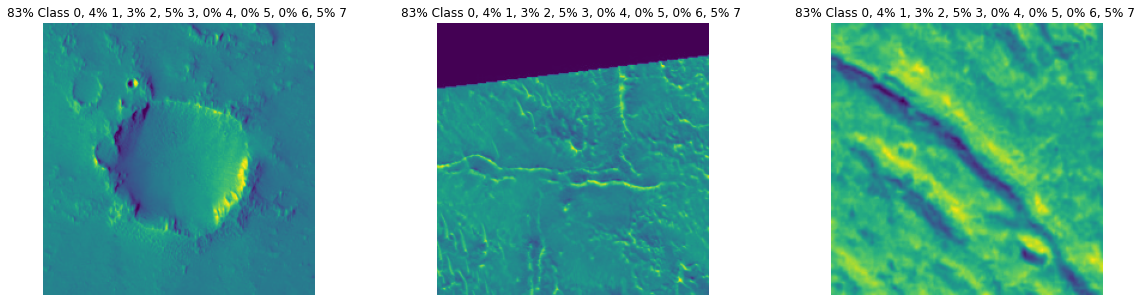

In [ ]:
fig, axs = plt.subplots(1, len(test_imgs), figsize=(20, 5))
for i, img in enumerate(test_imgs):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Class 0, {:.0f}% 1, {:.0f}% 2, {:.0f}% 3, {:.0f}% 4, {:.0f}% 5, {:.0f}% 6, {:.0f}% 7 ".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1],
                                                            100*pred_probs[i,2],
                                                            100*pred_probs[i,3],
                                                            100*pred_probs[i,4],
                                                            100*pred_probs[i,5],
                                                            100*pred_probs[i,6],
                                                            100*pred_probs[i,7],))
    ax.imshow(img)

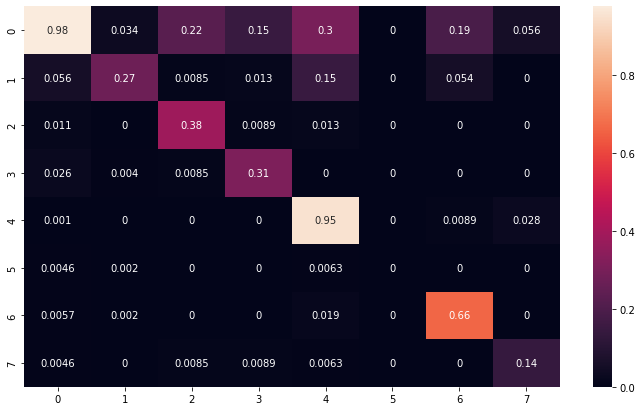

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels, _ in test_iterator:
        inputs = inputs.float().to(dev)
        labels = labels.to(dev)
        output = pretrained_model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', '2', '3', '4',
        '5', '6', '7')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

## Using deep explainer

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 11.0 MB/s eta 0:00:00


In [ ]:
batch = next(iter(test_iterator))
images, _, _ = batch
images = images.view(-1, 1, 227, 227)

In [ ]:
images.shape

torch.Size([64, 1, 227, 227])

In [ ]:
background = images[5:65]
test_images= images[0:5]

In [ ]:
background

tensor([[[[ 53,  51,  49,  ..., 149, 155, 156],
          [ 48,  49,  49,  ..., 146, 155, 159],
          [ 45,  48,  50,  ..., 144, 154, 161],
          ...,
          [145, 150, 158,  ..., 153, 166, 175],
          [150, 154, 160,  ..., 153, 164, 171],
          [154, 158, 163,  ..., 155, 163, 167]]],


        [[[166, 163, 156,  ..., 162, 157, 154],
          [169, 164, 155,  ..., 161, 155, 150],
          [174, 167, 154,  ..., 157, 150, 144],
          ...,
          [161, 154, 143,  ...,  48,  47,  45],
          [158, 154, 146,  ...,  49,  49,  49],
          [155, 154, 149,  ...,  50,  51,  52]]],


        [[[154, 154, 154,  ..., 111, 110, 110],
          [154, 154, 154,  ..., 118, 116, 115],
          [153, 153, 153,  ..., 127, 125, 123],
          ...,
          [162, 161, 160,  ..., 136, 136, 136],
          [165, 164, 162,  ..., 139, 138, 138],
          [167, 166, 164,  ..., 140, 140, 139]]],


        ...,


        [[[199, 200, 196,  ..., 160, 160, 160],
          [197, 

In [ ]:
test_images

tensor([[[[104, 105, 106,  ..., 154, 154, 153],
          [104, 104, 103,  ..., 151, 153, 154],
          [104, 103, 100,  ..., 146, 151, 155],
          ...,
          [147, 155, 173,  ..., 104, 104, 105],
          [149, 156, 173,  ..., 102, 101, 101],
          [151, 157, 173,  ..., 101, 100,  98]]],


        [[[194, 196, 195,  ..., 182, 181, 182],
          [193, 197, 196,  ..., 180, 180, 181],
          [194, 198, 195,  ..., 178, 178, 181],
          ...,
          [200, 194, 193,  ..., 213, 204, 200],
          [195, 189, 190,  ..., 215, 204, 197],
          [191, 184, 188,  ..., 216, 203, 194]]],


        [[[119, 121, 124,  ..., 129, 123, 118],
          [120, 122, 124,  ..., 131, 126, 122],
          [122, 123, 125,  ..., 134, 130, 128],
          ...,
          [137, 136, 136,  ..., 138, 140, 141],
          [137, 137, 138,  ..., 138, 140, 141],
          [137, 137, 139,  ..., 138, 140, 141]]],


        [[[109, 112, 116,  ..., 160, 161, 161],
          [117, 116, 115,  ...,

In [ ]:
import shap

In [ ]:
test_images.shape

torch.Size([5, 1, 227, 227])

In [ ]:
e = shap.DeepExplainer(pretrained_model, images.float().to(dev))
shap_values = e.shap_values(test_images)

In [ ]:
shap_values

[array([[[[-2.53777542e+01,  1.50028629e+01, -2.85317764e+01, ...,
            2.79702473e+01, -1.26314407e+02, -6.35373783e+00],
          [-2.82619873e+02, -1.26309456e+02, -2.54601612e+01, ...,
           -2.06023438e+02,  1.63444691e+01, -2.21300003e+02],
          [-1.60499146e+02,  9.03611832e+01,  6.38007812e+01, ...,
            1.55047211e+02,  3.06286438e+02, -1.61896935e+01],
          ...,
          [ 6.17270279e+00,  3.59547882e+01, -3.91119965e+02, ...,
           -1.57905655e+02, -1.93061447e+02,  5.73728516e+02],
          [-9.33425980e+01,  6.27488037e+02, -1.80879837e+02, ...,
           -1.61003403e+02,  6.50390778e+01,  4.26625900e+01],
          [ 2.16026505e+02,  2.73509430e+02, -3.50780670e+02, ...,
           -2.93321716e+02,  1.43896236e+01,  1.18113281e+02]]],
 
 
        [[[ 3.22794250e+02,  3.68940277e+02,  7.63064575e+01, ...,
            1.60839569e+02,  3.06131073e+02, -6.08461189e+01],
          [-6.47820435e+01, -4.68397369e+02,  5.37634201e+01, ...,
  

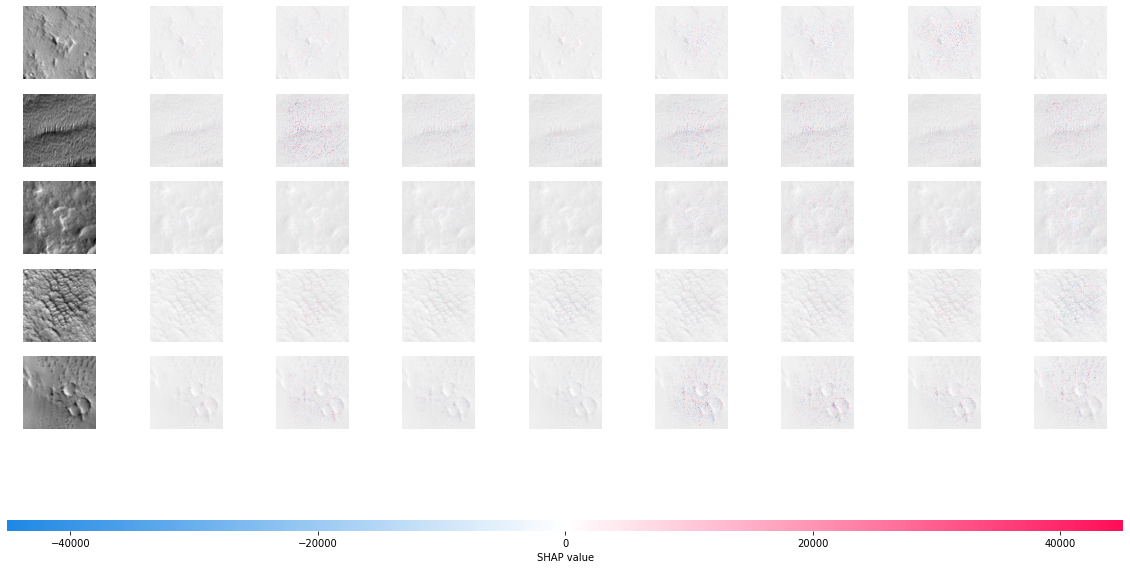

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)

## GradCAM

In [ ]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        #PRETRAINED MODEL
        self.pretrained = pretrained_model
        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out

In [ ]:
from PIL import Image
import matplotlib

In [ ]:
gcmodel = GradCamModel().to('cuda')

In [ ]:
images_list = []

In [ ]:
for img,_,_ in test_gradcam_iterator:
  images_list.append(img)

In [ ]:
test_img = '/content/AllDatasets/test/ESP_011425_1775_RED-0035-fv.jpg'

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
image = Image.open('/content/AllDatasets/test/ESP_011425_1775_RED-0035-fv.jpg')
transform = transforms.ToTensor()
inpimg = transform(image).resize(1,1,227,227)

/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
inpimg = images_list[2]

torch.Size([1, 8])


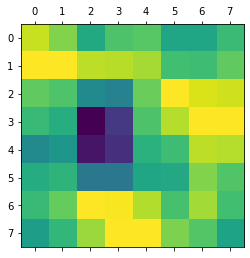

In [ ]:
out, acts = gcmodel(inpimg.float().to('cuda'))
acts = acts.detach().cpu()
print(out.shape)
loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array([2])).to('cuda'))
loss.backward()
grads = gcmodel.get_act_grads().detach().cpu()
pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()
for i in range(acts.shape[1]):
 acts[:,i,:,:] *= pooled_grads[i]
heatmap_j = torch.mean(acts, dim = 1).squeeze()
heatmap_j_max = heatmap_j.max(axis = 0)[0]
heatmap_j /= heatmap_j_max
plt.matshow(heatmap_j.squeeze())

In [ ]:
heatmap_j.shape

torch.Size([8, 8])

In [ ]:
heatmap_j = heatmap_j.numpy()

In [ ]:
# cmap = matplotlib.cm.get_cmap('jet',256)
# heatmap_j2 = cmap(heatmap_j,alpha = 0.2)

In [ ]:
img = inpimg.numpy()

In [ ]:
img = np.resize(img, (227,227))

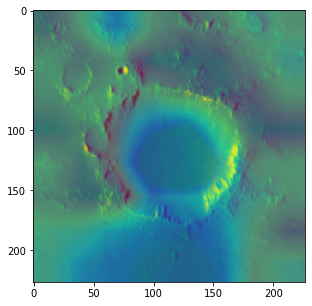

In [ ]:
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow(img)
axs.imshow(heatmap_j2)
plt.show()

In [ ]:
heatmap_j = cv2.resize(heatmap_j, (227,227))
heatmap = np.uint8(255 * heatmap_j)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
# superimposed_img = heatmap * 0.4 + img_rgb
# cv2.imwrite('./map.jpg', superimposed_img)

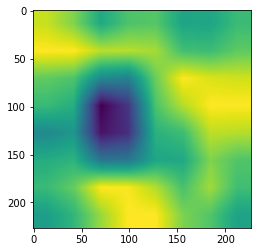

In [ ]:
plt.imshow(heatmap_j)

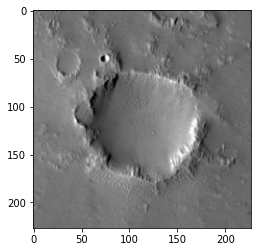

In [ ]:
plt.imshow(img_rgb)

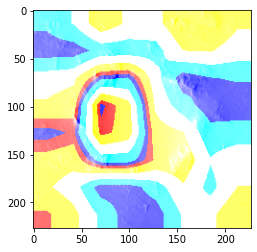

In [ ]:
plt.imshow(heatmap + img_rgb)